# Importación de Módulos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import reservoirpy as rpy

from sklearn.model_selection import train_test_split
from IPython.display import display

# Importar los datos

In [2]:
# Importar los datos

# Guarda los nombres únicos de las primeras dos columnas.
index_col_names=['unit_id','time_cycle']
# Genera los nombres del primer set de columnas con formato, estas son las de operational setting n.
operat_set_col_names=['oper_set{}'.format(i) for i in range(1,4)]
# Genera los nombres del segundo set de columnas con formato, estas son las de sensor measurement n.
sensor_measure_col_names=['sm_{}'.format(i) for i in range(1,22)]
# Pone todos los títulos en una lista
all_col=index_col_names+operat_set_col_names+sensor_measure_col_names

# Importa los datos desde el .txt com su nombre de columna en un dataframe.
train_df=pd.read_csv('train.txt',delim_whitespace=True,names=all_col)
train_df

C:\Users\dave4\AppData\Local\Temp\ipykernel_19552\1475424004.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df=pd.read_csv('train.txt',delim_whitespace=True,names=all_col)


,unit_id,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,...,130.21,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985
45914,218,130,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,...,130.24,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741
45915,218,131,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,...,129.86,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978
45916,218,132,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,...,182.03,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761


# Calcular RUL

In [3]:
# Primero se encuentra el ciclo de tiempo máximo para cada motor.

max_time_cycle=train_df.groupby('unit_id')['time_cycle'].max()

rul = pd.DataFrame(max_time_cycle).reset_index()
rul.columns = ['unit_id', 'max']
rul

,unit_id,max
0,1,223
1,2,164
2,3,150
3,4,159
4,5,357
...,...,...
213,214,150
214,215,156
215,216,190
216,217,287


In [4]:
# Se calcula el RUL para cada fila con un id específico y se le resta al máximo.

train_df = train_df.merge(rul, on=['unit_id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['time_cycle']
train_df.drop('max', axis=1, inplace=True)
train_df[train_df.unit_id==1].iloc[:,[1,-1]]

,time_cycle,RUL
0,1,222
1,2,221
2,3,220
3,4,219
4,5,218
...,...,...
218,219,4
219,220,3
220,221,2
221,222,1


In [5]:
display(train_df.describe())

,unit_id,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21,RUL
count,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,...,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000
mean,109.396511,110.307396,24.008881,0.571251,49.172438,472.861677,579.596770,1419.947816,1205.669194,8.029878,...,2334.185381,8065.548831,9.332433,0.023354,348.293915,2228.342654,97.741699,20.776822,12.466282,109.307396
std,62.866193,68.420545,14.793676,0.310935,32.503659,26.460179,37.391068,106.286960,119.550936,3.627125,...,128.426495,84.964099,0.751834,0.004722,27.837602,145.693883,5.378969,9.903697,5.941954,68.420545
min,1.000000,1.000000,0.000000,0.000000,0.000000,445.000000,535.650000,1245.430000,1029.490000,3.910000,...,2027.720000,7851.590000,8.325300,0.020000,303.000000,1915.000000,84.930000,10.230000,6.126600,0.000000
25%,54.000000,53.000000,10.004500,0.250600,20.000000,445.000000,549.580000,1352.910000,1124.010000,3.910000,...,2387.880000,8061.230000,8.676925,0.020000,331.000000,2212.000000,100.000000,10.840000,6.504600,52.000000
50%,110.000000,106.000000,25.001500,0.700000,40.000000,462.540000,555.985000,1369.140000,1138.870000,7.050000,...,2388.070000,8081.475000,9.314500,0.020000,335.000000,2223.000000,100.000000,14.870000,8.925200,105.000000
75%,164.000000,160.000000,41.998100,0.840000,80.000000,491.190000,607.370000,1499.697500,1307.437500,10.520000,...,2388.160000,8126.380000,9.390000,0.030000,369.000000,2324.000000,100.000000,28.470000,17.084200,159.000000
max,218.000000,357.000000,42.008000,0.842000,100.000000,518.670000,644.430000,1614.660000,1442.360000,14.620000,...,2390.740000,8274.880000,11.082600,0.030000,398.000000,2388.000000,100.000000,39.330000,23.590500,356.000000


# Normalizar

In [6]:
train_stats = train_df.describe()

# Se transpone el DataFrame para que las columnas y filas se inviertan entre ellas.
train_stats = train_stats.transpose()

def norm(x, stats):
    return((x-stats['min'])/(stats['max']-stats['min'])) #min-max norm

def reverse_norm(x):
    return(x*(train_stats['max']-train_stats['min'])+train_stats['min'])

norm_train_df = norm(train_df, train_stats)
norm_train_df

,unit_id,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21,RUL
0,0.0,0.000000,0.238162,0.297031,0.2,0.597937,0.629527,0.687972,0.679294,0.617180,...,0.992810,0.636065,0.107460,1.0,0.684211,0.854123,1.0,0.630584,0.632556,0.623596
1,0.0,0.002809,0.000036,0.000356,1.0,1.000000,0.978856,0.918452,0.906993,1.000000,...,0.992865,0.664509,0.023719,1.0,0.926316,1.000000,1.0,0.988316,0.986910,0.620787
2,0.0,0.005618,0.833141,0.997743,0.6,0.060269,0.181743,0.332422,0.225253,0.146592,...,0.992314,0.501429,0.373699,0.0,0.326316,0.651163,1.0,0.158076,0.156259,0.617978
3,0.0,0.008427,0.476174,0.831948,0.0,0.626985,0.656187,0.658153,0.532105,0.507937,...,0.992645,0.474167,0.325608,0.0,0.642105,0.864693,1.0,0.487629,0.495685,0.615169
4,0.0,0.011236,0.999907,0.998219,0.4,0.000000,0.127505,0.295344,0.229685,0.000000,...,0.992149,0.548277,0.352990,0.0,0.284211,0.627907,1.0,0.026117,0.015798,0.612360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,1.0,0.359551,0.999967,0.997625,0.4,0.000000,0.141294,0.324567,0.285659,0.000000,...,0.990772,0.499138,0.414137,0.0,0.315789,0.627907,1.0,0.011684,0.009843,0.011236
45914,1.0,0.362360,0.999879,0.999406,0.4,0.000000,0.132561,0.325326,0.273016,0.000000,...,0.990469,0.497201,0.412215,0.0,0.305263,0.627907,1.0,0.005842,0.008446,0.008427
45915,1.0,0.365169,0.999807,0.997625,0.4,0.000000,0.131182,0.308155,0.292247,0.000000,...,0.990607,0.498807,0.419758,0.0,0.326316,0.627907,1.0,0.004811,0.004077,0.005618
45916,1.0,0.367978,0.833191,0.999881,0.6,0.060269,0.192131,0.364597,0.280960,0.146592,...,0.991240,0.452692,0.397454,0.0,0.357895,0.651163,1.0,0.153608,0.145987,0.002809


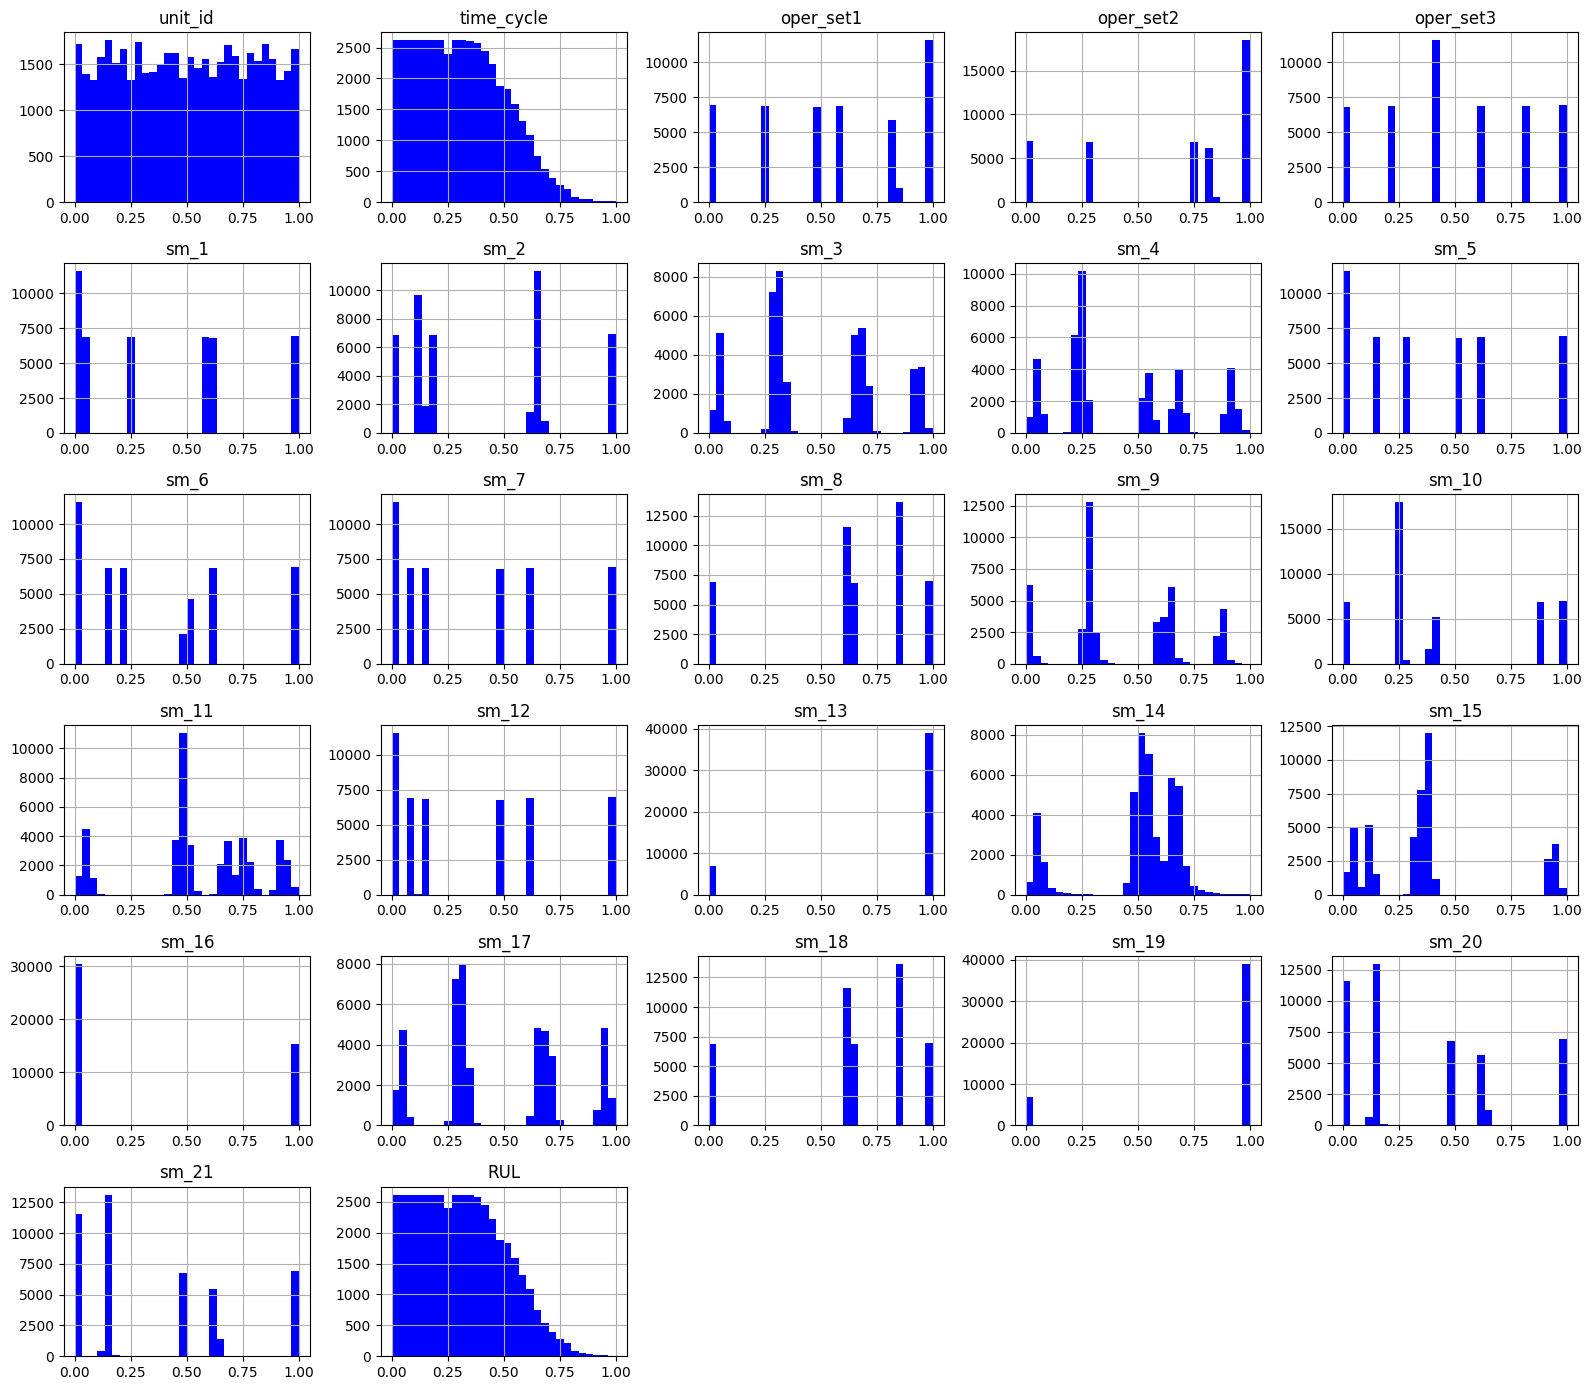

In [7]:
norm_train_df.hist(bins=30, figsize=(16,14), color='b')
plt.tight_layout()
plt.show()

# Filtro de Kalman

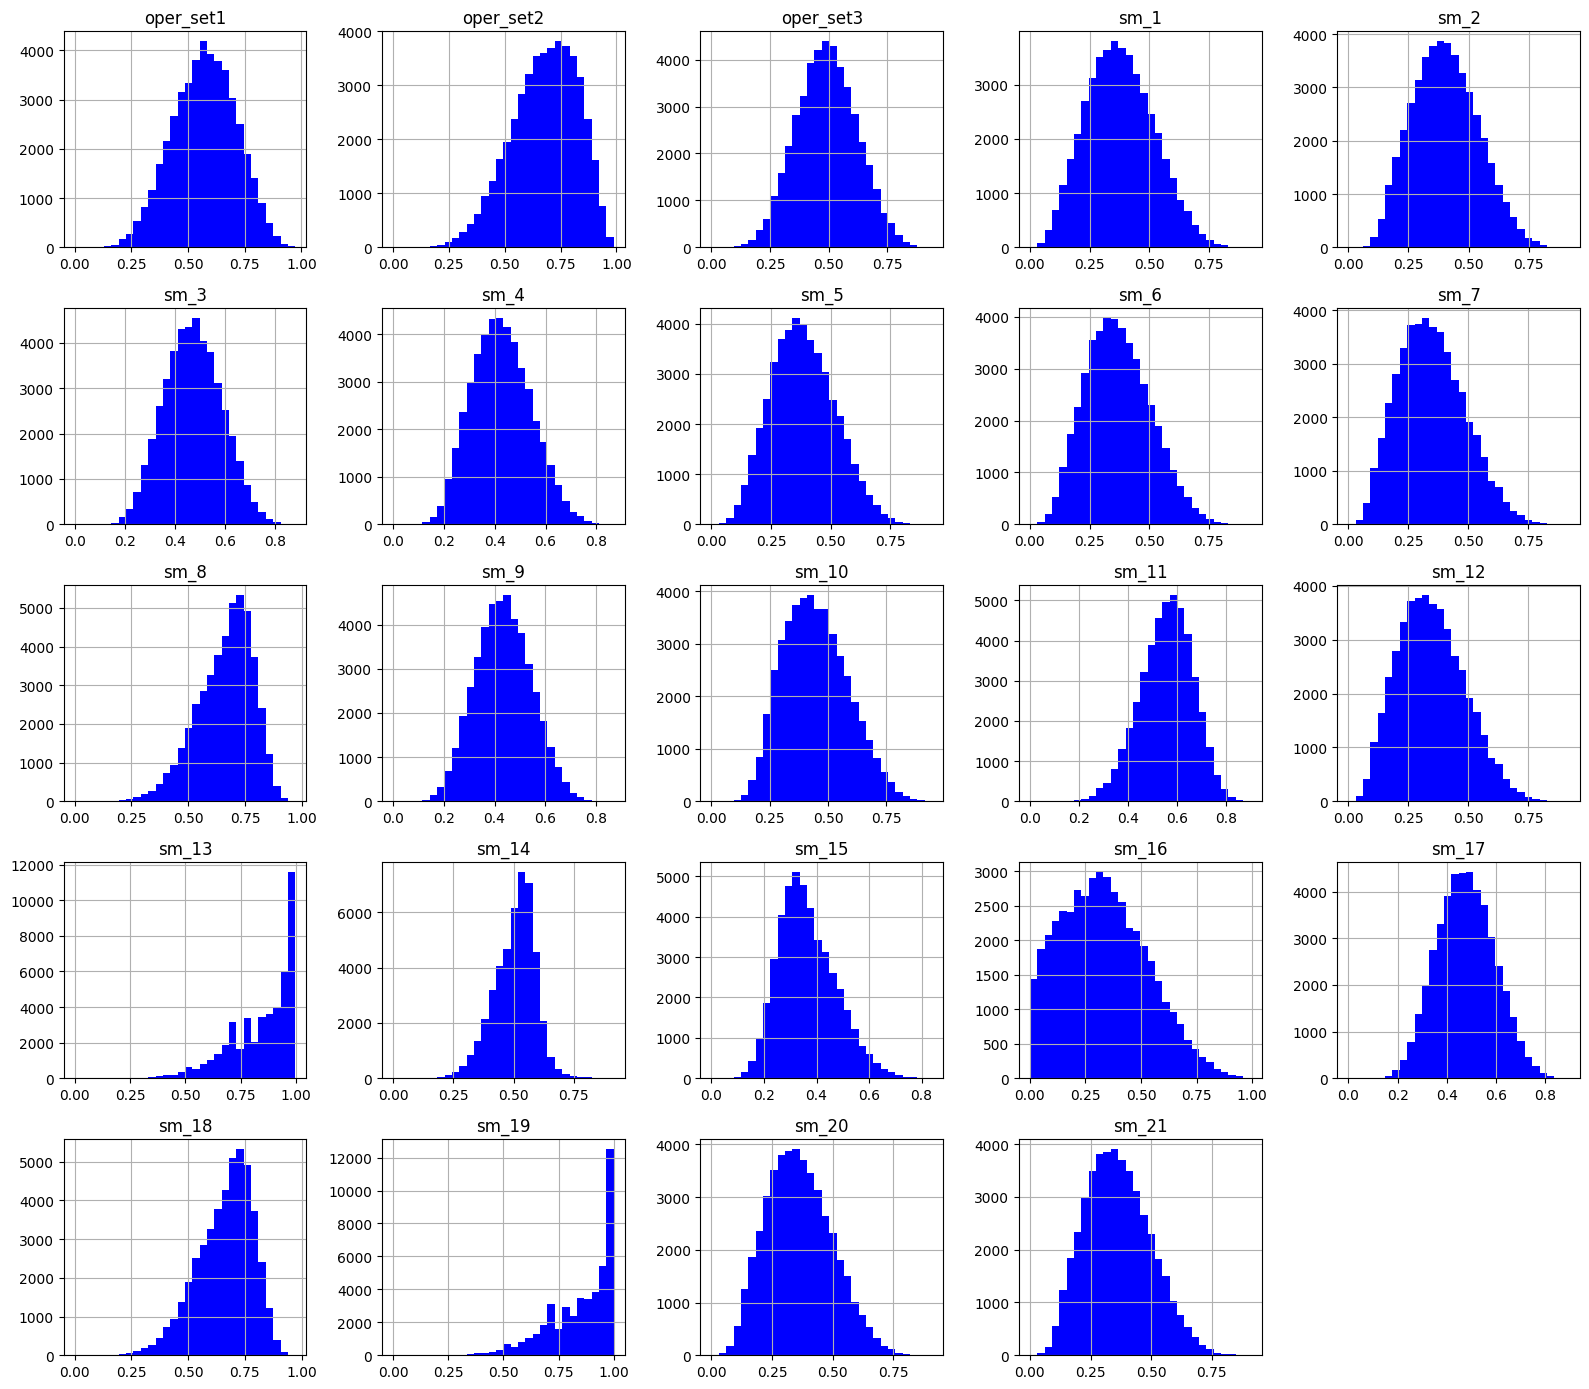

In [8]:
def kalman_filter(data, R, Q, P=1, x_init=0):

    n = len(data)
    x_hat = np.zeros(n)  
    P_est = np.zeros(n)  

    # Initial values
    x_hat[0] = x_init
    P_est[0] = P

    for k in range(1, n):
        # Predicción
        x_pred = x_hat[k-1] 
        P_pred = P_est[k-1] + Q  # Covarianza predicha
        
        # Actualizar ganancia
        K = P_pred / (P_pred + R)  # Kalman gain
        x_hat[k] = x_pred + K * (data[k] - x_pred) 
        P_est[k] = (1 - K) * P_pred  # Actualiza error de  covarianza
    
    return x_hat

# Se hace una copia de los datos normalizados sin filtar
norm_filt_train_df = norm_train_df

# Se filtran solo los datos de los sensores y los operation settings
sensor_columns = norm_filt_train_df.columns[2:26]

filtered_train_df = pd.DataFrame()

for sensor in sensor_columns:
    filtered_train_df[sensor] = kalman_filter(norm_filt_train_df[sensor].values, 0.1, 0.01)
    
filtered_train_df.hist(bins=30, figsize=(16,14), color='b')
plt.tight_layout()
plt.show()

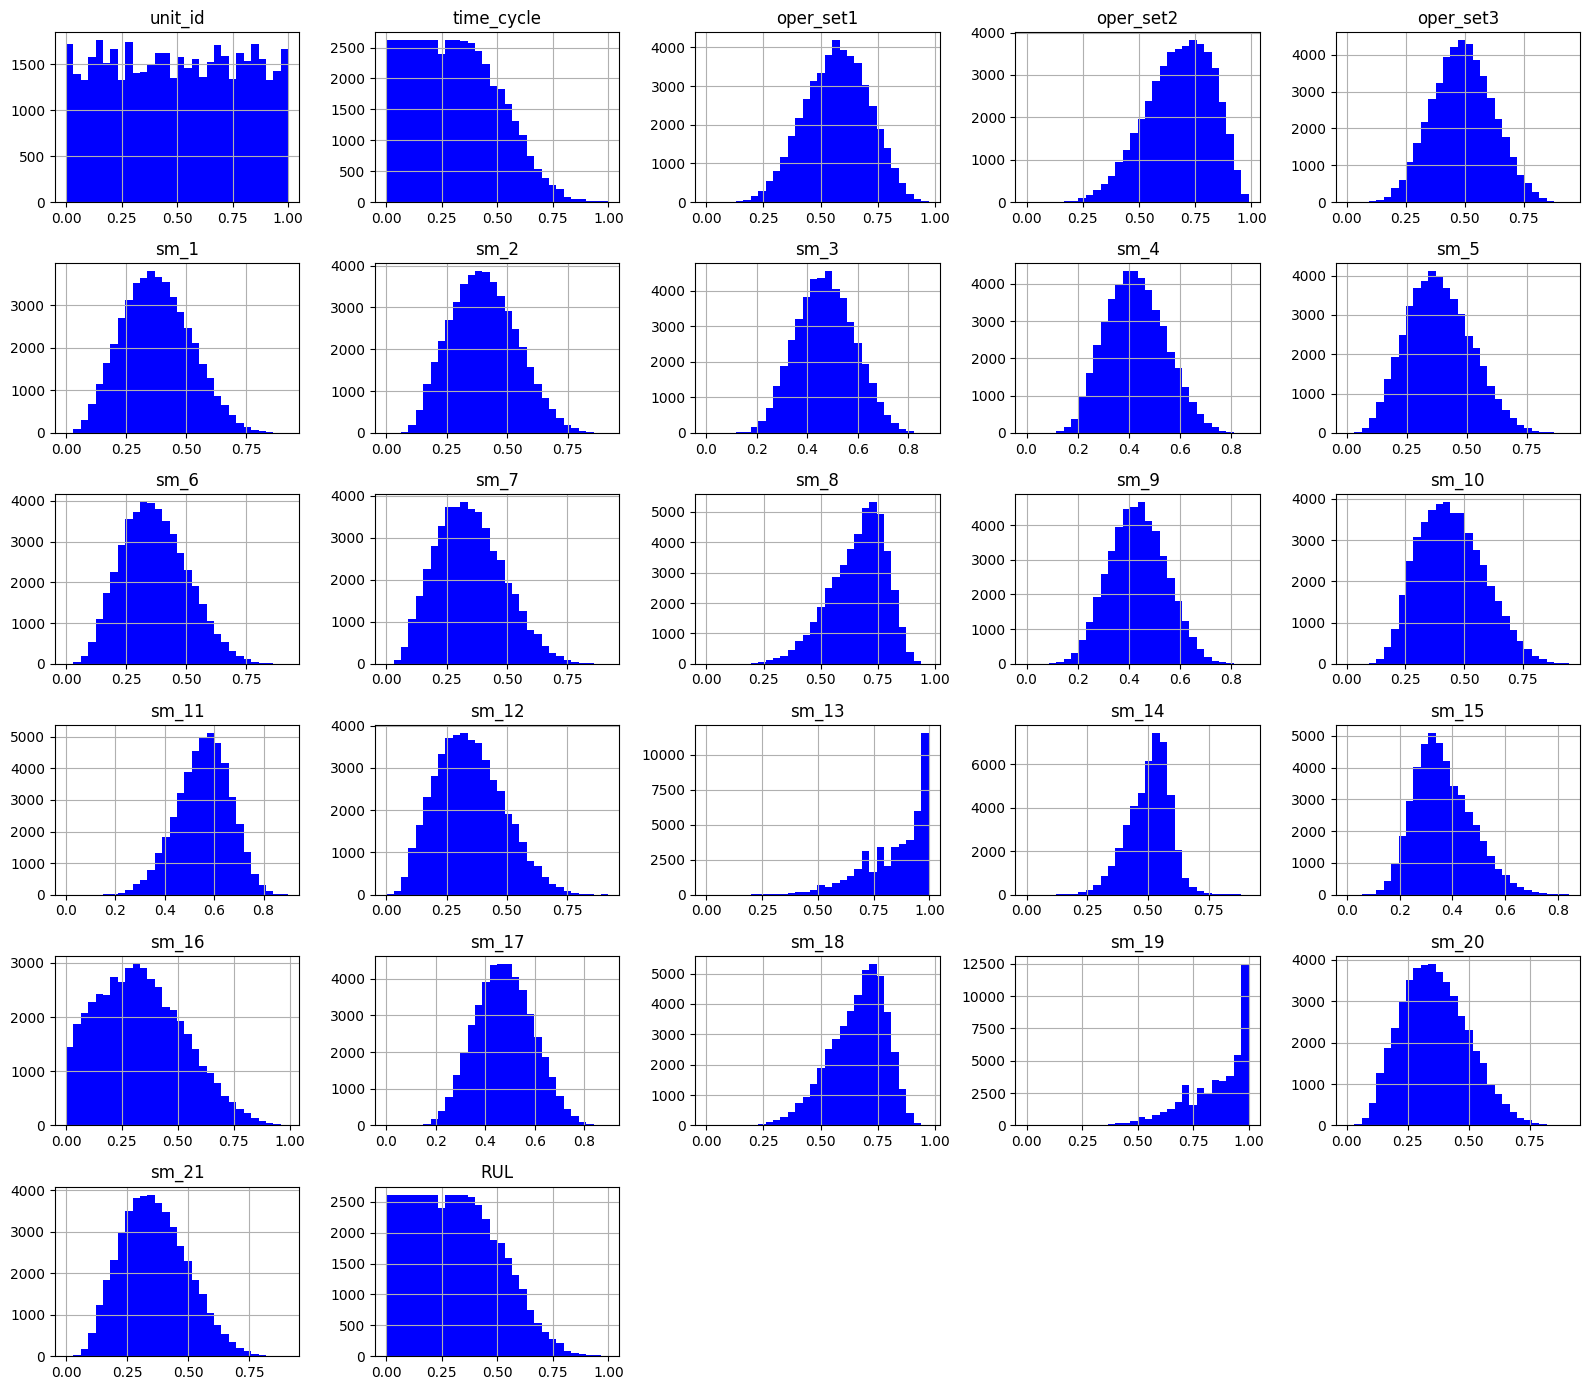

In [9]:
# Se mezclan los datos de ambos dataframes para crear uno con los datos normalizados y filtrados.
norm_filt_train_df.iloc[:, 2:26] = filtered_train_df.iloc[:, 0:24]

# Se muestran los datos de todo el dataframe normalizado y filtrado.
norm_filt_train_df.hist(bins=30, figsize=(16,14), color='b')
plt.tight_layout()
plt.show()

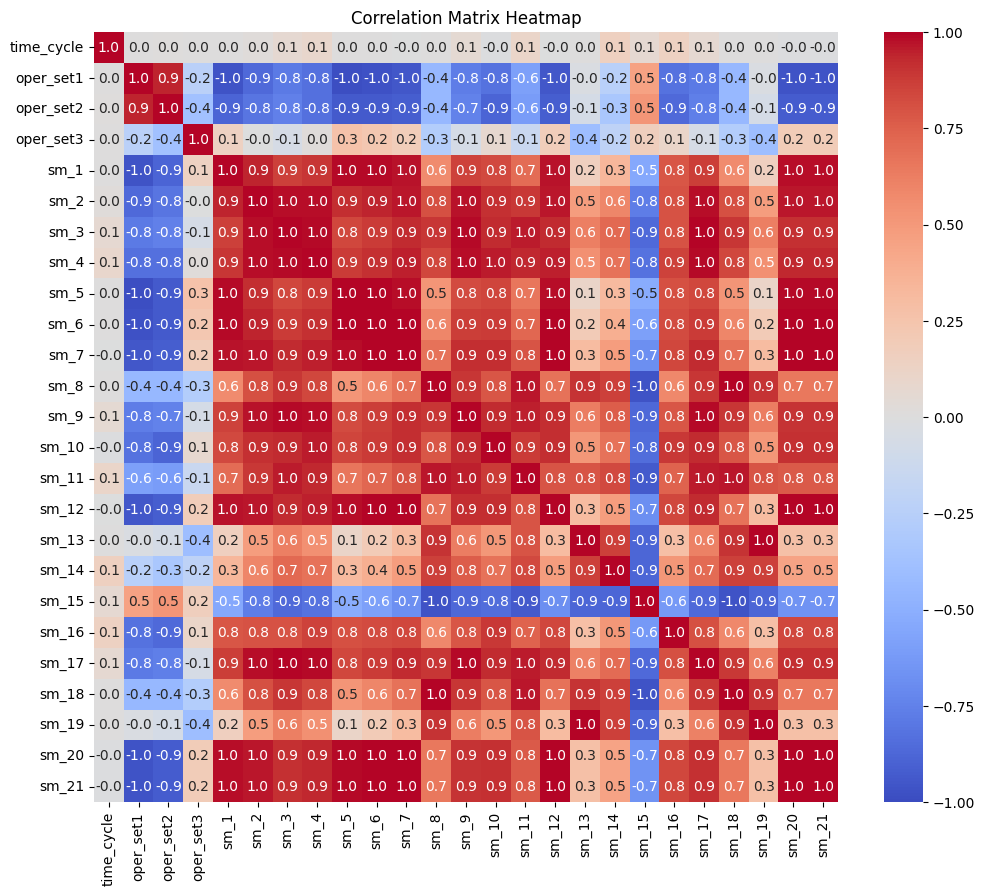

In [10]:
# Se crea una matriz de correlación y se grafica

correlation_matrix = norm_filt_train_df.iloc[:,1:-1].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create the heatmap with rounded annotations
sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap='coolwarm', vmin=-1, vmax=1)

# Show the plot
plt.title("Correlation Matrix Heatmap")
plt.show()

# Crear subset de validación

In [11]:
# Separar los datos por ID.
unit_ids = norm_filt_train_df['unit_id'].unique()

# Se hacen dos grupos de datos, 80% test y 20% validación
train_engines, val_engines = train_test_split(unit_ids, test_size=0.2, random_state=42)

# Se acomodan los datos por ID
train_data = norm_filt_train_df[norm_train_df['unit_id'].isin(train_engines)]
val_data = norm_filt_train_df[norm_train_df['unit_id'].isin(val_engines)]

# Se quitan los IDs de los datos
train_data.pop('unit_id')
val_data.pop('unit_id')

# Se separan los labels de los set de datos de entrenamiento y validación
train_label = train_data.pop('RUL')
val_label = val_data.pop('RUL')

In [12]:

# Los dataframes se convierten en arreglos de numpy
X_train = train_data.values  # (n_samples, n_features)
y_train = train_label.values.flatten()  # (n_samples)

# Se crea una secuencia temporal con estos datos
time_steps = 500  # Longitud de la secuencia temporal

# Se crean las secuencias para los features y el label
X_train_seq = []
y_train_seq = []

for i in range(len(X_train) - time_steps):
    X_train_seq.append(X_train[i:i + time_steps]) # Secuencia de features
    y_train_seq.append(y_train[i + time_steps])  # El label para el siguiente paso de tiempo

X_train_seq = np.array(X_train_seq)  # (n_samples, time_steps, n_features)
y_train_seq = np.array(y_train_seq)  # (n_samples,)

# Se cambia la forma de los datos de entrada
n_samples = X_train_seq.shape[0]
X_train_flat = X_train_seq.reshape(n_samples, -1)  # (n_samples, time_steps * n_features)

#se vuelve a convertir las labels en una columna
y_train_seq = y_train_seq.reshape(-1, 1)

# Se hace lo mismo para el set de validación

X_val = val_data.values
y_val = val_label.values.flatten()

X_val_seq = []
y_val_seq = []

for i in range(len(X_val) - time_steps):
    X_val_seq.append(X_val[i:i + time_steps])
    y_val_seq.append(y_val[i + time_steps])

X_val_seq = np.array(X_val_seq)
y_val_seq = np.array(y_val_seq)

n_samples = X_val_seq.shape[0]
X_val_flat = X_val_seq.reshape(n_samples, -1)

y_val_seq = y_val_seq.reshape(-1, 1)


In [13]:
print("Shape of X_train_seq:", X_val_flat.shape)
print("Shape of y_train_seq:", y_val_seq.shape)

Shape of X_train_seq: (8998, 12500)
Shape of y_train_seq: (8998, 1)


# Creación del modelo ESN

In [14]:
# primero se crea un reservoir

from reservoirpy.nodes import Reservoir, Ridge, Input

# Se definen los parámetros

#leaking rate
lr = 0.5

#spectral radius
sr = 0.9

#cant de neuronas
units = 200

#ridge
ridge = 1e-7

# Se crea la capa de datos 
data = Input()

# Se crea el resevoir y ridge del modelo
reservoir = Reservoir(units, lr, sr)
readout = Ridge(ridge=ridge)

reservoir <<= readout #conexión entre la salida y el reservoir (feedback)
esn_model = data >> reservoir >> readout & data >> readout

# Entrenamiento del modelo

In [125]:
try:
    esn_model.fit(X_train_flat, y_train_seq, force_teachers=True, warmup=100)
    print("Modelo entrenado exitosamente.")
except Exception as e:
    print("Error al entrenar el modelo:", e)

# Verificar el estado de inicialización
print(reservoir.is_initialized, readout.is_initialized)

Running Model-58: 35920it [00:19, 1879.46it/s]?, ?it/s]
Running Model-58: 100%|██████████| 1/1 [01:21<00:00, 81.08s/it]


Fitting node Ridge-55...
Modelo entrenado exitosamente.
True True


# Optimización de parámetros

In [15]:
from reservoirpy.observables import nrmse, rsquare

# Se define el objetivo de la función a optimizar

def objective(dataset, config, *, input_scaling, N, sr, lr, ridge, seed):
    x_train, y_train, x_test, y_test = dataset
    
    # You can access anything you put in the config file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances to be sure there is no bias in the results due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(
            units=N, 
            sr=sr, 
            lr=lr, 
            input_scaling=input_scaling, 
            seed=variable_seed
        )

        data = Input()
        readout = Ridge(ridge=ridge)

        reservoir <<= readout #conexión entre la salida y el reservoir (feedback)
        model = data >> reservoir >> readout & data >> readout


        # Train your model and test your model.
        predictions = model.fit(x_train, y_train) \
                        .run(x_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(x_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [ ]:
import json

# Se definen los parámetros a optimizar y sus límites
hyperopt_config = {
    "exp": "hyperopt-RUL",    # EL nombre del experimento
    "hp_max_evals": 200,              # la cantidad de sets de parámetros a testear
    "hp_method": "random",            # el método utilizado (random search)
    "seed": 42,                       # la seed, se mantiene igual para mantener reproducibilidad
    "instances_per_trial": 5,         # cuantos modelos aleatorios se prueban por conjunto de parámetros
    "hp_space": {                     # los rangos de los parámetros
        "N": ["choice", 50 ,150, 200, 300], # el número de neuronas se prueban diferentes valores
        "sr": ["loguniform", 1e-6, 10],   # el radio espectral es log uniforme entre 1e-6 y 10
        "lr": ["loguniform", 1e-3, 1],    # igual el leaking rate, pero entre 1e-3 y 1
        "input_scaling": ["choice", 1.0], # el escalamiento es fijo
        "ridge": ["loguniform", 1e-8, 1e1], # el ridge es log uniforme entre 1e-8 y 1e1
        "seed": ["choice", 1234]
    }
}

# Se guarda la configuración en un archivo json
# cada archivo empieza con un número correspondiente al número de experimento
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)
    
# Se preparan los datos 
dataset = (X_train_flat, y_train_seq, X_val_flat, y_val_seq)

In [22]:
# Se corre la búsqueda
from reservoirpy.hyper import research
best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

job exception: objective() missing 1 required keyword-only argument: 'seed'



  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]


TypeError: objective() missing 1 required keyword-only argument: 'seed'

In [ ]:
# Se muestran los resultados
from reservoirpy.hyper import plot_hyperopt_report
fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr", "ridge"), metric="r2")

# Haciendo predicciones

Running Model-58: 8998it [00:16, 554.30it/s]           


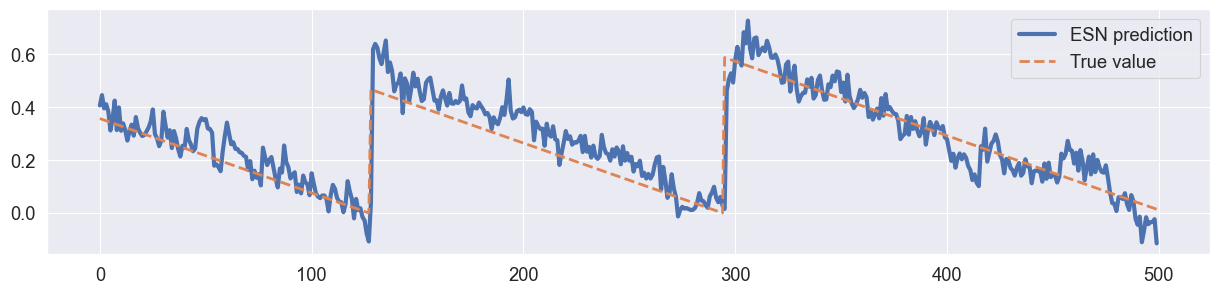

(-4.433901175891514, 0.5761960027387083)

In [126]:
# Se evalúa el modelo 
def plot_results(y_pred, y_test, sample=500):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
    #plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

    plt.legend()
    plt.show()
    
y_pred = esn_model.run(X_val_flat, forced_feedbacks=y_val_seq)
y_test = y_val_seq

plot_results(y_pred, y_test)
rsquare(y_test, y_pred), nrmse(y_test, y_pred)